##GPU Gacha!

In [ ]:
# If you want to reroll a new GPU, terminate current session and connect session again.
!/opt/bin/nvidia-smi

Mon Jun  7 08:33:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/thesis/SiamNetOmnieyes'

Mounted at /content/drive


##Import libraries

In [ ]:
import os
import random
import torchvision
from torchvision import transforms
import torch
from torch.optim import lr_scheduler
# import torch.optim as optim
from torch.autograd import Variable
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import torch.nn as nn
import torch.nn.functional as F
import pickle
from imgaug import augmenters as iaa
import json
import cv2
from copy import deepcopy

import zipfile
from io import BytesIO

!pip install torch-optimizer
import torch_optimizer as optim
from google.colab.patches import cv2_imshow
from IPython.display import display
from random import randrange

import math
!pip install haversine
from haversine import haversine, Unit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import glob

from itertools import combinations

     |████████████████████████████████| 81kB 2.5MB/s 


##Signboard Dataset setup

In [ ]:
def pickle_save(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
        
def pickle_load(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [ ]:
def read_obj_from_zip(unzipped_archive, data_path):
    '''
    read json or jpg from zip archive.
    
    returns: json or jpg; inputs other than json and jpg returns None.
    '''
    read_bytes = unzipped_archive.read(data_path)
    
    # check if data type is json or jpg and read the data respectively.
    if data_path.endswith('.json'):
        obj = json.loads(read_bytes.decode("utf-8"))
    elif data_path.endswith('.jpg'):
        data_encoded = BytesIO(read_bytes)
        try:
          img = cv2.imdecode(np.frombuffer(data_encoded.read(), np.uint8), 1) 
        except:
          img = None
        
        if img is not None:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = Image.fromarray(img)
        obj = img  
    else:
        obj = None


    return obj

In [ ]:
def read_zip_data(root_path):   
    # read zip data:
    '''
      data format: zip_dict = {date:{zip: zip_archive, zip_dict: zip_path_dict}, date:{zip: zip_archive, zip_dict: zip_path_dict}....}
      date: date of driving record
      zip_archive: zip data
      zip_path_dict: a dict contains all the file paths of zip data. Each date contains videos data separately.

      {
        '20200404:   {
                        zip: (zipfile archive)
                        zip_dict:   {
                                      '108-7B_01_20200404_073500':   {imgs: [A list of image paths refers to 108-7B_01_20200404_073500], json: JSON file of 108-7B_01_20200404_073500}
                                      ....
                                      ....
                                    }
                      },

        '20200405:   {
                        zip: (zipfile archive)
                        zip_dict:   {
                                      ...
                                      ... 
                                    }
                     },
        ...
        ...
      }

    '''
    zip_dir_list = glob.glob(root_path + '/*.zip')

    zip_dict = {}
    all_vid_path_list = []
    for zip_dir in zip_dir_list:
        zip_date = zip_dir.split('/')[-1].split('.')[0]

        print(f"Processing {zip_dir}...")
        z = zipfile.ZipFile(zip_dir, 'r')
        z_namelist = z.namelist()

        zip_path_dict = {}
        for obj_path in z_namelist:
            vid_path = obj_path.split('/')[1]
            # remove duplicate paths
            if '(1)' in obj_path:
                continue
            # save image data.
            else:       
                if obj_path.endswith('.jpg'):                              
                    if vid_path not in zip_path_dict.keys():
                        zip_path_dict[vid_path] = {'imgs':[obj_path], 'json':None}
                    else:
                        zip_path_dict[vid_path]['imgs'].append(obj_path)
                        
                elif obj_path.endswith('.json'):
                    if vid_path not in zip_path_dict.keys():
                        zip_path_dict[vid_path] = {'imgs':[], 'json':obj_path}
                    else:
                        zip_path_dict[vid_path]['json'] = obj_path

        zip_dict[zip_date] = {'zip': z, 'zip_dict': zip_path_dict}


    return zip_dict

In [ ]:
def read_group_paths(signboard_obj, max_length=-1):
    group_paths = []
    
    # max_length = -1 to read all frame_id images
    if max_length == -1:
        read_frame_id = signboard_obj.frame_id
    elif max_length == 0:
        print('Max length has set to 0. No images will be loaded.')
        return group_paths
    else:
        # handle frame_id length < max_length situations.
        k_value = min(len(signboard_obj.frame_id), max_length)
        read_frame_id = random.sample(signboard_obj.frame_id, k=k_value)


    input_signboard_trk_id = signboard_obj.trk_id
    
    # handling extended signboard track ids
    signboard_trk_id = input_signboard_trk_id.split('_')[0] if '_'in input_signboard_trk_id else input_signboard_trk_id

    for frame in signboard_obj.frame_id:           
        frame_file_name = f'track_{signboard_trk_id}_{frame}.jpg'
        trk_date, trk_vid_name = signboard_obj.date, signboard_obj.vid_name

        file_path = os.path.join(trk_date, trk_vid_name, 'tracks', frame_file_name)

        group_paths.append(file_path)

    return group_paths

In [ ]:
def form_dataset(filtered_result_paths, addBlurred=False, max_length=100):
    all_datasets = []
    label = 0
    for path in filtered_result_paths:
        dataset = []
        filter_results = pickle_load(path)[1]
        print('Group length:', len(filter_results))
        # group_elem_num = 0
        for filtered_sign_obj_group in filter_results:
            data_group = read_group_paths(filtered_sign_obj_group['query'])
            confirmed_group = [read_group_paths(sign_obj) for sign_obj in filtered_sign_obj_group['confirmed']]
            for group in confirmed_group:
                data_group += group

            if addBlurred:
                blurred_group = [read_group_paths(sign_obj) for sign_obj in filtered_sign_obj_group['blurred']]

                for group in blurred_group:
                    data_group += group
            
            # data balancing:
            if len(data_group) > max_length:
                # calculate sample data's balanced interval.
                data_sample_interval = int(len(data_group) / max_length)
                # when data_group is not enough to have a balance interval(interval = 1), random sample data.
                if data_sample_interval == 1:
                    data_group = random.sample(data_group, k=max_length)
                else:
                    data_group = [data_group[i * data_sample_interval] for i in range(max_length)]

            # labeling
            data_group = [[data, label] for data in data_group]

            dataset.append(data_group)
            label += 1
        all_datasets.append(dataset)
        
    return all_datasets

In [ ]:
 # A class that stored a tracked signboard information
class SignBoard(object):
    def __init__(self, trk_record_info, trk_id, date, vid_name):# , trk_path):
        # self.trk_data_path = trk_path
        self.frame_id = trk_record_info['frame_id']

        self.gps_list = [[math.radians(trk_gps[1]), math.radians(trk_gps[0])] for trk_gps in trk_record_info['gps']]

        self.gps_median = statistics.median_low(self.gps_list)

        self.trk_id = trk_id

        self.date = date

        self.vid_name = vid_name
    

####read tracked data

In [ ]:
### relocate this path to your corresponding drive path;
trk_info_root_path = '/content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results'

### and also relocate team members folder path.
team_folder_path = '/content/drive/My Drive/To_team_members'

car_name = '108-7B'
car_trk_info_root_path = os.path.join(trk_info_root_path, car_name)

zip_dict = read_zip_data(car_trk_info_root_path)

Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200404.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200418.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200413.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200416.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200414.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200428.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200417.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200405.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200422.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108

####read filtered data and form dataset

In [ ]:
filtered_data_path = '/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints'

all_members_paths = glob.glob(os.path.join(filtered_data_path, '*'))

all_members_latest_paths = []

for member_path in all_members_paths:
    list_of_files = glob.glob(os.path.join(member_path, '*.pickle'))
    latest_file = max(list_of_files, key=os.path.getctime)
    all_members_latest_paths.append(latest_file)
    print(latest_file)

/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Vitor/group_5_checkpoint_611.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Sebastian/group_4_checkpoint_109.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/James/group_1_checkpoint_600.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Jasper/group_6_checkpoint_475.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Darren/group_0_checkpoint_164.pickle


In [ ]:
labeled_dataset = form_dataset(all_members_latest_paths, max_length=40)

Group length: 611
Group length: 109
Group length: 600
Group length: 475
Group length: 164


##Signboard dataset


In [ ]:
def expand2square(pil_img):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), (0, 0, 0))
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), (0, 0, 0))
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

####Data augmentations

In [ ]:
val_transforms = transforms.Compose([
                # transforms.Lambda(expand2square),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

val_padding_transforms = transforms.Compose([
                transforms.Lambda(expand2square),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


####Dataset class

In [ ]:
class TripletSignboard_v2():
    def __init__(self, zip_dict=None, dataset=[], batch_size=64, transforms=None, isTrain=True):
        self.zip_dict = zip_dict
        self.transforms = transforms
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffled_dataset = []
        self.isTrain = isTrain


    def data_shuffle(self):
        shuffle_data = deepcopy(self.dataset)
        random.shuffle(shuffle_data)
        # shuffle_sequences = random.sample(range(len(shuffle_data)), k=len(shuffle_data))
        full_batches = []
        while shuffle_data:
            filtered_group_set = shuffle_data.pop(0)
            while True:
                total_filtered_elem = sum([len(data) for data in filtered_group_set])
                # if filtered group set's elements cannot fill a batch, then stop shuffling on this group set.
                if total_filtered_elem < self.batch_size:
                    break
                # pick a group randomly.
                rand_group_choice = random.choice(range(len(filtered_group_set)))
                # if the group has less than 2 elements (cannot form a positive pair), then find another group.
                if len(filtered_group_set[rand_group_choice]) < 2:
                    continue
                    
                # pick 2 elements to confirm existing a positive pair in the batch.
                rand_elem_choices = sorted(random.sample(range(len(filtered_group_set[rand_group_choice])), k=2), reverse=True)
                batch = [filtered_group_set[rand_group_choice].pop(choice) for choice in rand_elem_choices]

                batch_cnt = self.batch_size - 2

                while batch_cnt > 0:                   
                    batch_rand_group_choice = random.choice(range(len(filtered_group_set)))
                    # skip if the group has no elements.
                    if len(filtered_group_set[batch_rand_group_choice]) < 1:
                        continue
                    # pick an random element from random group.
                    batch_rand_elem_choice = random.choice(range(len(filtered_group_set[batch_rand_group_choice])))
                    batch.append(filtered_group_set[batch_rand_group_choice].pop(batch_rand_elem_choice))


                    batch_cnt -= 1
                
                # batch label check (at least 2 different labels to form negative pairs.)
                isSameLabel = True

                batch_current_label = batch[0][1]
                for batch_data in batch:
                      if batch_data[1] != batch_current_label:
                          isSameLabel = False
                
                if isSameLabel:
                    continue
                else:
                    if self.isTrain:
                        random.shuffle(batch)
                    full_batches += batch

        self.shuffled_dataset = full_batches

      
    def __getitem__(self,index):     
        data = self.shuffled_dataset[index]

        # set label
        label = data[1]
        
        # read query image
        img_path = data[0]     
        img_date = img_path.split('/')[0]

        img = read_obj_from_zip(self.zip_dict[img_date]['zip'], img_path)

        # Apply image transformations
        if self.transforms is not None:
            trans_img = self.transforms(img)
        else:
            trans_img = img

        return trans_img , label

    
    def __len__(self):
        return len(self.shuffled_dataset)

##EmbeddingNet

In [ ]:
class EmbeddingResnet(nn.Module):
    def __init__(self, fixed_blocks=0):
        super(EmbeddingResnet, self).__init__()

        resnet = torchvision.models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Fix blocks
        for p in self.features[0].parameters():
            p.requires_grad = False
        for p in self.features[1].parameters():
            p.requires_grad = False
        if fixed_blocks >= 3:
            for p in self.features[6].parameters():
                p.requires_grad = False
        if fixed_blocks >= 2:
            for p in self.features[5].parameters():
                p.requires_grad = False
        if fixed_blocks >= 1:
            for p in self.features[4].parameters():
                p.requires_grad = False

        def set_bn_fix(m):
            classname = m.__class__.__name__
            if classname.find('BatchNorm') != -1:
                for p in m.parameters(): p.requires_grad = False

        self.features.apply(set_bn_fix)

    def forward(self, x):
        features = self.features.forward(x)
        features = features.view(features.size(0), -1)
        # features = F.normalize(features, p=2, dim=1)
        return features

##test_epoch

In [ ]:
# ########## Calculate element-wise Euclidean distance ############
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
# def cos_sim(vectors):
#     distance_matrix = F.cosine_similarity(vectors.unsqueeze(1), vectors.unsqueeze(0), dim=2, eps=1e-10)

#     return distance_matrix

In [ ]:
def img_read_and_draw_info(data, label='', distance='', size=(300, 300), draw_info=True, single_img=False):
    if single_img:
        input_date = data.split('/')[0]
        input_img = read_obj_from_zip(zip_dict[input_date]['zip'], data)
        info_img = expand2square(input_img).resize(size)
    else:
        # pick the median image as showcase image.
        draw_path = data[int(len(data) / 2)]
        while True:
            input_date = draw_path.split('/')[0]
            input_img = read_obj_from_zip(zip_dict[input_date]['zip'], draw_path)

            # if the current choice is not accessible, then randomly choose one and try again.
            if input_img is None:
                draw_path = random.choice(data)
                continue

        info_img = expand2square(input_img).resize(size)
   
    # drawing text size 
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', size=32)
    draw_img = ImageDraw.Draw(info_img) 

    if draw_info:
        draw_id = f'Label:{label}'
        draw_img.text((10, 10), draw_id, font=font, fill ="red", align ="left")

        if distance != '':
            draw_dist = f'Dist:{distance:.4f}'    
            draw_img.text((10, size[1] - 80), draw_dist, font=font, fill ="blue", align ="left")

        return info_img

    else:
        draw_id = f'Label:{label}'
        draw_img.text((10, 10), draw_id, font=font, fill ="red", align ="left")

        draw_msg = 'Query'
 
        draw_img.text((10, size[1] - 80), draw_msg, font=font, fill ="green", align ="left")

        return info_img


In [ ]:
def show_draw_list(draw_list, max_column=5):
    # calculate the number of rows if we draw the list from left to right, with column number 'max_column'.


    draw_row_num = math.ceil( (len(draw_list) / max_column) )


    for row_id in range(draw_row_num):
        row_draw_list = draw_list[(row_id * max_column):((row_id + 1) * max_column)]
        row_img = np.hstack( (np.asarray(img) for img in row_draw_list ) )


        # pad row_img if image numbers < max_column.
        if row_id != 0 and len(row_draw_list) < max_column:
            height, width = row_draw_list[0].size
            list_width = (width * len(row_draw_list))
            row_width = (width * max_column)
            padding_width = row_width - list_width
            pad_img = np.zeros((height, padding_width, 3), np.uint8)
            row_img = np.hstack( (row_img, pad_img) )

        if row_id == 0:
            row_imgs = row_img
        else:
            row_imgs = np.vstack( (row_imgs, row_img) )

    row_imgs = cv2.cvtColor(row_imgs, cv2.COLOR_RGB2BGR)
    cv2_imshow(row_imgs)

In [ ]:
def calculate_embedding(img, comparison_model, transform=None):
      with torch.no_grad():          
          if transform is not None:
                img = transform(img)

          if cuda:
                img = img.cuda()
          
          # change rois shape into a patch like size.
          img = torch.unsqueeze(img, 0)

          
          img_embedding = comparison_model(img)


      return img_embedding

In [ ]:
def evaluations(val_set, val_embeddings, top_N=10, show_drawings=False, comb_proportion=2, show_rate=1.0, max_trials=25000):
       
        top_1_score = 0
        top_5_score = 0
        top_10_score = 0
        total_trials = 0
        ####### added on 2021-04-13
        top1_top2_dist_list = []

        for group_id in range(len(val_set)):
            other_groups = deepcopy(val_set)
            query_group = other_groups.pop(group_id)
            other_groups_embeddings = deepcopy(val_embeddings)
            query_group_embeddings = other_groups_embeddings.pop(group_id)


            # find all combinations from query group.
            query_combinations = list(combinations(range(len(query_group)), r=2))

            # due to numerous calculation time, reduced combinations to comb_proportion.
            interval_num = int(len(query_combinations)/comb_proportion)
            comb_interval = int(len(query_combinations) / interval_num)
            query_combinations = [query_combinations[i * comb_interval] for i in range(interval_num)]
            # query_combinations = random.sample(query_combinations, k=(int(len(query_combinations)/comb_proportion)) )


            # combine the embeddings from other groups and record the data paths(after we need to relocate the corresponding image.)
            ref_cal_list = []
            embedding_cal_list = []
            show_sample = True

            for ref_group_id in range(len(other_groups)):
                  ref_group = other_groups[ref_group_id]
                  ref_group_embeddings = other_groups_embeddings[ref_group_id]
                  
                  ref_cal_list += ref_group
                  embedding_cal_list += ref_group_embeddings

            for q_combination in query_combinations:
                first_query_data = deepcopy(query_group[q_combination[0]])
                second_query_data = deepcopy(query_group[q_combination[1]])
              
                query_path = first_query_data[0]
                query_label = first_query_data[1]

                query_embeddings = [query_group_embeddings[q_combination[0]], query_group_embeddings[q_combination[1]] ]

                # initialize ranking list

                ranking_list = [second_query_data] + deepcopy(ref_cal_list)


                # stack all embeddings               
                eval_embeddings = torch.stack(query_embeddings + deepcopy(embedding_cal_list))

                '''find out all distances between query_data and the signboards of other groups.'''

                # calculate embedding distances
                #### L2 norm ####
                # distance_matrix = torch.cdist(eval_embeddings, eval_embeddings, p=2, compute_mode='donot_use_mm_for_euclid_dist')[0].tolist()
                distance_matrix = torch.cdist(eval_embeddings, eval_embeddings, p=2)[0].tolist()
                #### Cosine similarity ####
                # distance_matrix = (1.0 - cos_sim(eval_embeddings)[0]).tolist()

                # pop query distance, which is 0.
                dummy = distance_matrix.pop(0)

                # combine predicted distances, paths and labels. Then sorted them followed by predicted distances.
                for dist_id, distance in enumerate(distance_matrix):
                    ranking_list[dist_id].insert(0, distance)

                # sort top-N ranking followed by predicted distances.
                sorted_ranking_list = sorted(ranking_list)[:top_N]

                if show_drawings:
                    draw_list = [img_read_and_draw_info(query_path, label=query_label, 
                                                            distance='', size=(250, 250), draw_info=False, single_img=True)]

                # show ranking results and calculate calculate prediction score.

                for rank_idx, candidate_data in enumerate(sorted_ranking_list):
                    candidate_distance = candidate_data[0]
                    candidate_img_path = candidate_data[1]
                    candidate_label = candidate_data[2]
                    # print(candidate_label)
                    if candidate_label == query_label:
                          if rank_idx == 0:
                              top_1_score += 1
                              top2_candidate_dist = sorted_ranking_list[1][0]
                              top1_top2_dist = top2_candidate_dist - candidate_distance
                              top1_top2_dist_list.append(top1_top2_dist)
                              
                          elif rank_idx < 5:
                              top_5_score += 1
                          elif rank_idx < 10:
                              top_10_score += 1


                    if show_drawings and show_sample:
                        draw_list.append(img_read_and_draw_info(candidate_img_path, label=candidate_label, 
                                                            distance=candidate_distance, size=(250, 250), draw_info=True, single_img=True) )
                
                if show_drawings and show_sample:
                    show_chance = random.random()
                    if show_chance <= show_rate:                 
                        show_draw_list(draw_list, max_column=top_N + 1)
                    show_sample = False

                total_trials += 1
                
                if total_trials % 2500 == 0:
                    print(f'top 1 score: {top_1_score / total_trials * 100.}%')
                    print(f'top 5 score: {(top_5_score + top_1_score) / total_trials * 100.}%')
                    print(f'top 10 score: {(top_5_score + top_1_score + top_10_score) / total_trials * 100.}%')

                    average_top1_top2_dist = np.mean(np.array(top1_top2_dist_list))
                    print(f'\naverage distance difference between True positive top1 candidate and top2 candidate: {average_top1_top2_dist}')
                    print('\ntotal trials:', total_trials)
                    print('================================================')
            
            if total_trials >= max_trials:
                break
          
        print(f'final top 1 score: {top_1_score / total_trials * 100.}%')
        print(f'final top 5 score: {(top_5_score + top_1_score) / total_trials * 100.}%')
        print(f'final top 10 score: {(top_5_score + top_1_score + top_10_score) / total_trials * 100.}%')
        
        average_top1_top2_dist = np.mean(np.array(top1_top2_dist_list))
        print(f'\naverage distance difference between True positive top1 candidate and top2 candidate: {average_top1_top2_dist}')
        print('\ntotal trials:', total_trials)
        print('================================================')
        # break



##basic setup

In [ ]:
cuda = torch.cuda.is_available()

batch_size = 512

# if you want to use scheduler, please turn it on and set milestones numbers you want.
useScheduler = True
milestones_num = 2

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the network and training parameters
model_folder_name = 'comparison/Triplet/Track_filtered_data_Triplet_no_pretrain/'
embedded_model_name = 'Track_filtered_data_Triplet_no_pretrain_epoch_'

start_epoch = 0

margin = 3.0
# embedding_net = EmbeddingResnet(fixed_blocks=2)
embedding_net = EmbeddingResnet()

if cuda:
    embedding_net.cuda()

# loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))

# lr = 1e-3
# optimizer = optim.RAdam(embedding_net.parameters(), lr=lr)


# n_epochs = 300

# # added scheduler
# if useScheduler:
#     milestones_interval = int(n_epochs / (milestones_num + 1) )

#     m_interval_list = [i * milestones_interval for i in range(1, milestones_num + 1)]
#     print('milestones_interval:', m_interval_list)

#     scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=m_interval_list, gamma=0.1)
# else:
#     scheduler = None

# log_interval = 20

# history_log = {'train':[], 'val':[]}
embedding_net.eval()

####load model

In [ ]:
# model_folder_name = 'comparison/Triplet/Manual_filtered_data_Triplet_Res50_resize_margin_2_semi_hard_e100/'
# model_name = 'Manual_filtered_data_Triplet_Res50_resize_margin_2_semi_hard_e100_epoch_'
# embedded_model_name = 'Manual_filtered_data_Triplet_Res50_resize_margin_2_semi_hard_e100_embedded_epoch_'

model_folder_name = 'comparison/Triplet/Track_filtered_data_Triplet_Darren/'
embedded_model_name = 'Track_filtered_data_Triplet_Darren_epoch_'


cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

start_epoch = 600
load_epoch = start_epoch - 1

history_log = {'train':[], 'val':[]}
with open( (drive_path + '/history/' + model_folder_name + embedded_model_name + str(load_epoch) +".txt" ) , 'rb') as hist_read:
# with open( (drive_path + '/history/' + model_folder_name + model_name + str(load_epoch) +".txt" ) , 'rb') as hist_read:
        history_log = pickle.load(hist_read)
        
embedding_net = EmbeddingResnet(fixed_blocks=2)

if cuda:
    embedding_net.cuda()
    
embedding_net.load_state_dict(torch.load(drive_path + "/models/" + model_folder_name + embedded_model_name + str(load_epoch) + ".pt"))
embedding_net.eval()

EmbeddingResnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

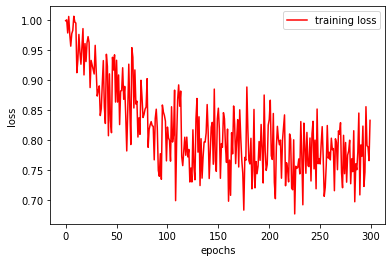

In [ ]:
# previous filtered data training loss curve
plt.plot(history_log['train'], 'r-', label='training loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

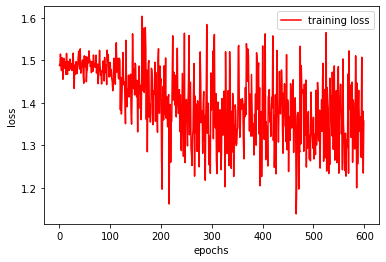

In [ ]:
# latest filtered data training loss curve
plt.plot(history_log['train'], 'r-', label='training loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

###Evaluations

In [ ]:
temp_dataset = deepcopy(labeled_dataset)
test_labeled_dataset = temp_dataset.pop(4)
train_labeled_dataset = temp_dataset

In [ ]:
print(len(test_labeled_dataset))

164


In [ ]:
#### Calculate embeddings ####

isPadded = False

test_labeled_dataset_embeddings = []
# image_groups_embeddings = pickle_load(embedding_save_path + '/embeddings_53000_groups.pickle')

print("Calculating embeddings...")
for idx, group in enumerate(test_labeled_dataset):
      if idx !=0 and idx % 20 == 0:
          print(f"{idx} groups embeddings have been calculated.")
          # pickle_save(embedding_save_path + f'/embeddings_{idx}_groups.pickle', image_groups_embeddings)

      
      group_embeddings = []
      for data in group:
            data_path = data[0]
            data_date = data_path.split('/')[0]
            data_img = read_obj_from_zip(zip_dict[data_date]['zip'], data_path)   
            if isPadded:       
                data_embedding = calculate_embedding(data_img, embedding_net, transform=val_padding_transforms)
            else:
                data_embedding = calculate_embedding(data_img, embedding_net, transform=val_transforms)


            group_embeddings.append(data_embedding.squeeze())

      test_labeled_dataset_embeddings.append(group_embeddings)

print("Embedding calculations have been finished.")

# pickle_save(embedding_save_path + f'/all_embeddings_groups.pickle', image_groups_embeddings)

Calculating embeddings...
20 groups embeddings have been calculated.
40 groups embeddings have been calculated.
60 groups embeddings have been calculated.
80 groups embeddings have been calculated.
100 groups embeddings have been calculated.
120 groups embeddings have been calculated.
140 groups embeddings have been calculated.
160 groups embeddings have been calculated.
Embedding calculations have been finished.


In [ ]:
evaluations(test_labeled_dataset, test_labeled_dataset_embeddings, show_drawings=True, comb_proportion=3, max_trials=10000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # ImageNet Pretrained Res50 model
# # ================================================
# top 1 score: 47.82%
# top 5 score: 53.269999999999996%
# top 10 score: 56.37%

# average distance difference between True positive top1 candidate and top2 candidate: 4.143519282440718

# total trials: 10000
# ================================================

In [ ]:
# # model trained with latest filterd data: margin 4.0
# # ================================================
# top 1 score: 53.080000000000005%
# top 5 score: 62.32%
# top 10 score: 67.17999999999999%

# average distance difference between True positive top1 candidate and top2 candidate: 3.3162085528695324

# total trials: 10000
# ================================================

In [ ]:
# # model trained with latest filterd data: margin 2.0
# # ================================================
# top 1 score: 41.8%
# top 5 score: 50.86000000000001%
# top 10 score: 55.63%

# average distance difference between True positive top1 candidate and top2 candidate: 1.8546635465830137

# total trials: 10000
# ================================================

In [ ]:
# # model trained with latest filterd data: margin 2.0, pos_num 8

# top 1 score: 55.92%
# top 5 score: 64.41%
# top 10 score: 68.02%

# average distance difference between True positive top1 candidate and top2 candidate: 2.770895930606664

# total trials: 10000
# ================================================

In [ ]:
# # model trained with latest filterd data: margin 2.0, batch 256

# top 1 score: 54.58%
# top 5 score: 64.86%
# top 10 score: 69.28999999999999%

# average distance difference between True positive top1 candidate and top2 candidate: 2.9674603291246298

# total trials: 10000
# ================================================

In [ ]:
# # model trained with latest filterd data: margin 3.0, batch 512, fixed group size 40 epoch 300

# top 1 score: 70.19999999999999%
# top 5 score: 77.74%
# top 10 score: 80.67999999999999%

# average distance difference between True positive top1 candidate and top2 candidate: 4.776466120529039

# total trials: 10000
# ================================================
# epoch 600
# top 1 score: 70.83%
# top 5 score: 77.66999999999999%
# top 10 score: 80.81%

# average distance difference between True positive top1 candidate and top2 candidate: 4.791285267736924

# total trials: 10000
# ================================================

In [ ]:
# # model trained with previous filterd data 
# ================================================

# top 1 score: 55.300000000000004%
# top 5 score: 64.38000000000001%
# top 10 score: 67.81%

# average distance difference between True positive top1 candidate and top2 candidate: 2.1693224000187077

# total trials: 10000
# ================================================